In [ ]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
from cellpose import utils, io, models, plot
from scipy.spatial import distance as dist
import re
import tools
from radfil import radfil_class, styles
from astropy import units as u
import imageio.v2 as imageio
import copy
from PIL import Image
from fil_finder import FilFinder2D
from shapely.geometry import Polygon
from skimage.util import invert
from skimage.morphology import skeletonize
from cv2 import imwrite
from tools import prune2
from scipy.interpolate import splprep
from scipy.interpolate import splev
from IPython.core.display import HTML
from scipy.signal import argrelextrema
import random

date = "06-03-2015"
my_data = "../data/" + date + "/Height/"
my_pfe = "../data/" + date + "/Peak_Force_Error/"
my_apm = "../data/" + date + "/Amplitude/"
my_sti = "../data/" + date + "/Stiffness/"
segments_path = "../cellpose_outputs/" + date + "/Height/"
cell_path = "Individual_cells/"
diam = 60
flow = 0.8

## Run Cellpose

In [26]:
# Load up a list of input files from our example data.
files = os.listdir(my_data)
for fichier in files[:]:
    if not(fichier.endswith(".png")):
        files.remove(fichier)
        
# Sort files by timepoint.
files.sort(key = tools.natural_keys)      

# Create a list that contains the full path to each of our image files. 
save_names = [segments_path + file for file in files]
file_names = [my_data + file for file in files]

## Not necessary, so long as diameter and flow threshold are known

In [55]:
# Specify that the cytoplasm Cellpose model for the segmentation. 
model = models.Cellpose(gpu=True, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
channels = [0,0]

# Loop over all of our image files and run Cellpose on each of them. 
for filename, savename in zip(file_names, save_names):
    img = io.imread(filename)
    masks, flows, styles,diams = model.eval(img, diameter = diam, channels=channels, flow_threshold = flow,min_size=2000)

    # save results so you can load in gui
    io.masks_flows_to_seg(img, masks, flows, diams, savename, channels)

    #save results as png
    io.save_to_png(img, masks, flows, savename)

In [27]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

In [28]:
def remove_large_masks(array,max_size=-1):
    ''' Removes all masks above a certain area threshold. Can be turned off by setting to -1'''
    if max_size==-1:
        return array
    else:
        unique,counts = np.unique(array,return_counts=True)
        area_dict=dict(zip(unique,counts))
        for ID in area_dict:
            if area_dict[ID]>max_size:
                array = array - ((array==ID)*ID)
        return array

In [42]:
# Initialize lists.
outl_temp = []
height_img_list = []
stiff_img_list = []
pfe_img_list = []
areal_unfiltered = []
areal_filtered = []

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    if len(dat['masks'])!=0:
        unique,counts=np.unique(dat['masks'],return_counts=True)
        areal_unfiltered= areal_unfiltered + list(counts[1:])
    # Remove small masks from the data
    dat["masks"] = utils.fill_holes_and_remove_small_masks(dat["masks"], min_size = 800)
    dat['masks'] = remove_large_masks(dat['masks'],max_size=-1)
    if len(dat['masks'])!=0:
        unique,counts=np.unique(dat['masks'],return_counts=True)
        areal_filtered = areal_filtered + list(counts[1:])
    # Populate list with each cell outline.
    outl = utils.outlines_list(dat['masks'])
    outl_temp.append(outl)
    
    # Populate list with each original image.
    image = dat["img"]
    height_img_list.append(image)
    
    # If it exists, read in the png with the stiffness and PFE.
    if os.path.exists(my_sti + str(time) + "_Stiffness.png") == True:
        stiff_img_list.append(imageio.imread(my_sti + str(time) + "_Stiffness.png"))
    else:
        stiff_img_list.append(np.nan)
        
    if os.path.exists(my_pfe + str(time) + "_PFE.png") == True:
        pfe_img_list.append(imageio.imread(my_pfe + str(time) + "_PFE.png"))
    else:
        pfe_img_list.append(np.nan)

(array([34., 59., 63., 71., 53., 35., 32., 19., 17., 15.,  7.,  2.,  1.,
         1.,  2.]),
 array([  859.        ,  1633.33333333,  2407.66666667,  3182.        ,
         3956.33333333,  4730.66666667,  5505.        ,  6279.33333333,
         7053.66666667,  7828.        ,  8602.33333333,  9376.66666667,
        10151.        , 10925.33333333, 11699.66666667, 12474.        ]),
 <BarContainer object of 15 artists>)

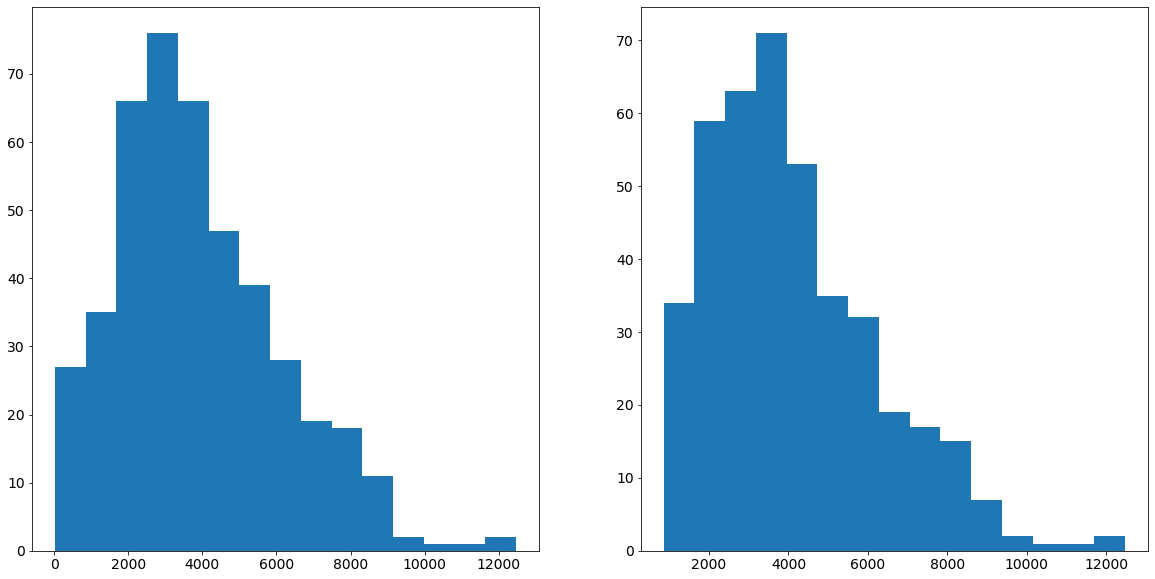

In [43]:
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].hist(areal_unfiltered,bins=15)
axs[1].hist(areal_filtered,bins=15)

In [44]:
# The image dictionary contains the complete images for all of the image types. 
img_dict = {
    "Height": height_img_list,
    "Stiffness": stiff_img_list,
    "PFE": pfe_img_list
    }
# The metadata dictionary will hold all of the data we want to save into our final table.
metadata_dict = {}

# The individual cell dictionary will save information for each individual cell such as the outline, skeleton, cropped image, etc. 
ind_cell_dict = {}

# The structural dictionary will hold information on the timepoint of each image, the cell IDs for each cell in each image,
# and the outlines and bounding boxes for each cell in each image.
structural_dict = {
    "Time": time_list
    }

In [45]:
# Initialize a list of boxes
boxes_temp = []
box_img = copy.deepcopy(height_img_list)

# Fill lists with the coordinates of bounding boxes for each cell outline.
for outl, img in zip(outl_temp, box_img):
    boxes = tools.get_boxes(outl)
    boxes_temp.append(boxes)
    for box in boxes:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)

In [46]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None)

# Initialize a new set of lists that will contain lists of IDs, outlines, and centers for each image file. 
IDs_list = []
outl_list = []
boxes_list = []
centers_list = []

# loop over the outlines and boxes for each file.
for boxes, img, outls in zip(boxes_temp, box_img, outl_temp):
    # update our centroid tracker using the computed set of bounding box rectangles
    if len(outls)!=0:
        objects = ct.update(boxes, outls)
    # Initialize a new set of lists
    IDs = []
    outl_new = []
    boxes_new = []
    centers = []
    # loop over the tracked objects
    if len(outls)!=0:
        for (objectID, info) in objects.items():
            # draw both the ID of the object and the centroid of the
            # object on the output frame
            text = "ID {}".format(objectID)
            cv2.putText(img, text, (info[1][0] - 10, info[1][1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.circle(img, (info[1][0], info[1][1]), 4, (0, 255, 0), -1)
            # append the object ID and its associated outline and center to the lists. 
            IDs.append(objectID)
            outl_new.append(info[2])
            centers.append(info[1])
            boxes_new.append(info[0])
    boxes_list.append(boxes_new)
    IDs_list.append(IDs)
    outl_list.append(outl_new)
    centers_list.append(centers)

In [47]:
# Add our new lists to the proper dictionaries. 
structural_dict["IDs"] = IDs_list
structural_dict["outlines"] = outl_list
structural_dict["bounding_boxes"] = boxes_list

metadata_dict["centroids"] = centers_list

# Destroy the temporary lists to get some more space. 
boxes_temp.clear()
outl_temp.clear()

## Find the number of masks as a timeseries

In [48]:
num_of_masks=[len(out_set) for out_set in structural_dict['outlines']]

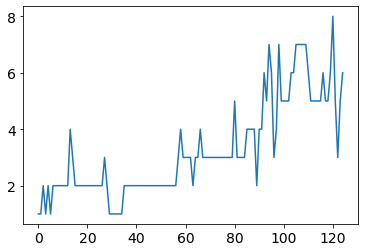

In [49]:
plt.plot(num_of_masks)

## Look for single mask jumps

In [55]:
def find_jumps(series,n):
    ''' Find the number of single jumps in a series
    
    Parameters
    ---------
    series = a time series of integer entries, arraylike
    n = the number of time points expected to remain constant before and after a jump
    '''
    def auto_cor(x,y):
        '''Helper function to find correlation of sequences of equal length'''
        result = np.correlate(x,y,mode='full')
        return result[result.size//2:][0]
    Y = np.array(list(np.zeros(n).astype(int)) + list(np.ones(n).astype(int)))-0.5
    corl = []
    for i in range (len(num_of_masks)-2*n):
        seq = num_of_masks[i:i+2*n]
        E = seq[0]
        X = (np.array(seq)-E-0.5)*2
        cor = auto_cor(X,Y)-abs(np.linalg.norm(X)-np.linalg.norm(Y))
        corl.append(cor)
    peaks=argrelextrema(np.array(corl),np.greater_equal,order=n)[0]
    jumps=[]
    for i in peaks:
        if corl[i]>n//2:
            jumps.append(i)
    if len(jumps)==0:
        return jumps,corl
    elif len(jumps)==1:
        fig,axs=plt.subplots(len(jumps),2*n,figsize=(10*2*n,10*len(jumps)))
        m = jumps[0]
        for ax in axs.flat:
            ax.set(ylabel = str(m))
            ax.label_outer()
        for j in range(2*n):
            ind = m+j
            dat = np.load(segments_path + segmented[ind], allow_pickle=True).item()
            maski= dat['masks']
            img = img_dict['Height'][ind]
            outlines=plot.outline_view(img,maski,color=[0,255,0])
            axs[j].imshow(outlines)
            axs[j].set_title (structural_dict['Time'][ind])
        return jumps,corl
    else:
        fig,axs=plt.subplots(len(jumps),2*n,figsize=(10*2*n,10*len(jumps)))
        for i in range(len(jumps)):
            m = jumps[i]
            for j in range(2*n):
                ind = m+j
                dat = np.load(segments_path + segmented[ind], allow_pickle=True).item()
                maski= dat['masks']
                img = img_dict['Height'][ind]
                outlines=plot.outline_view(img,maski,color=[0,255,0])
                axs[i,j].imshow(outlines)
                axs[i,j].set_title (structural_dict['Time'][ind])
                axs[i,j].set(ylabel = str(m))
                axs[i,j].label_outer()
        return jumps,corl

In [56]:
def essd(x,y):
    '''Take the exponential sum of squares difference between two time-series of the same length'''
    return sum([np.exp(-(x[i]-y[i])**2) for i in range (len(x))])

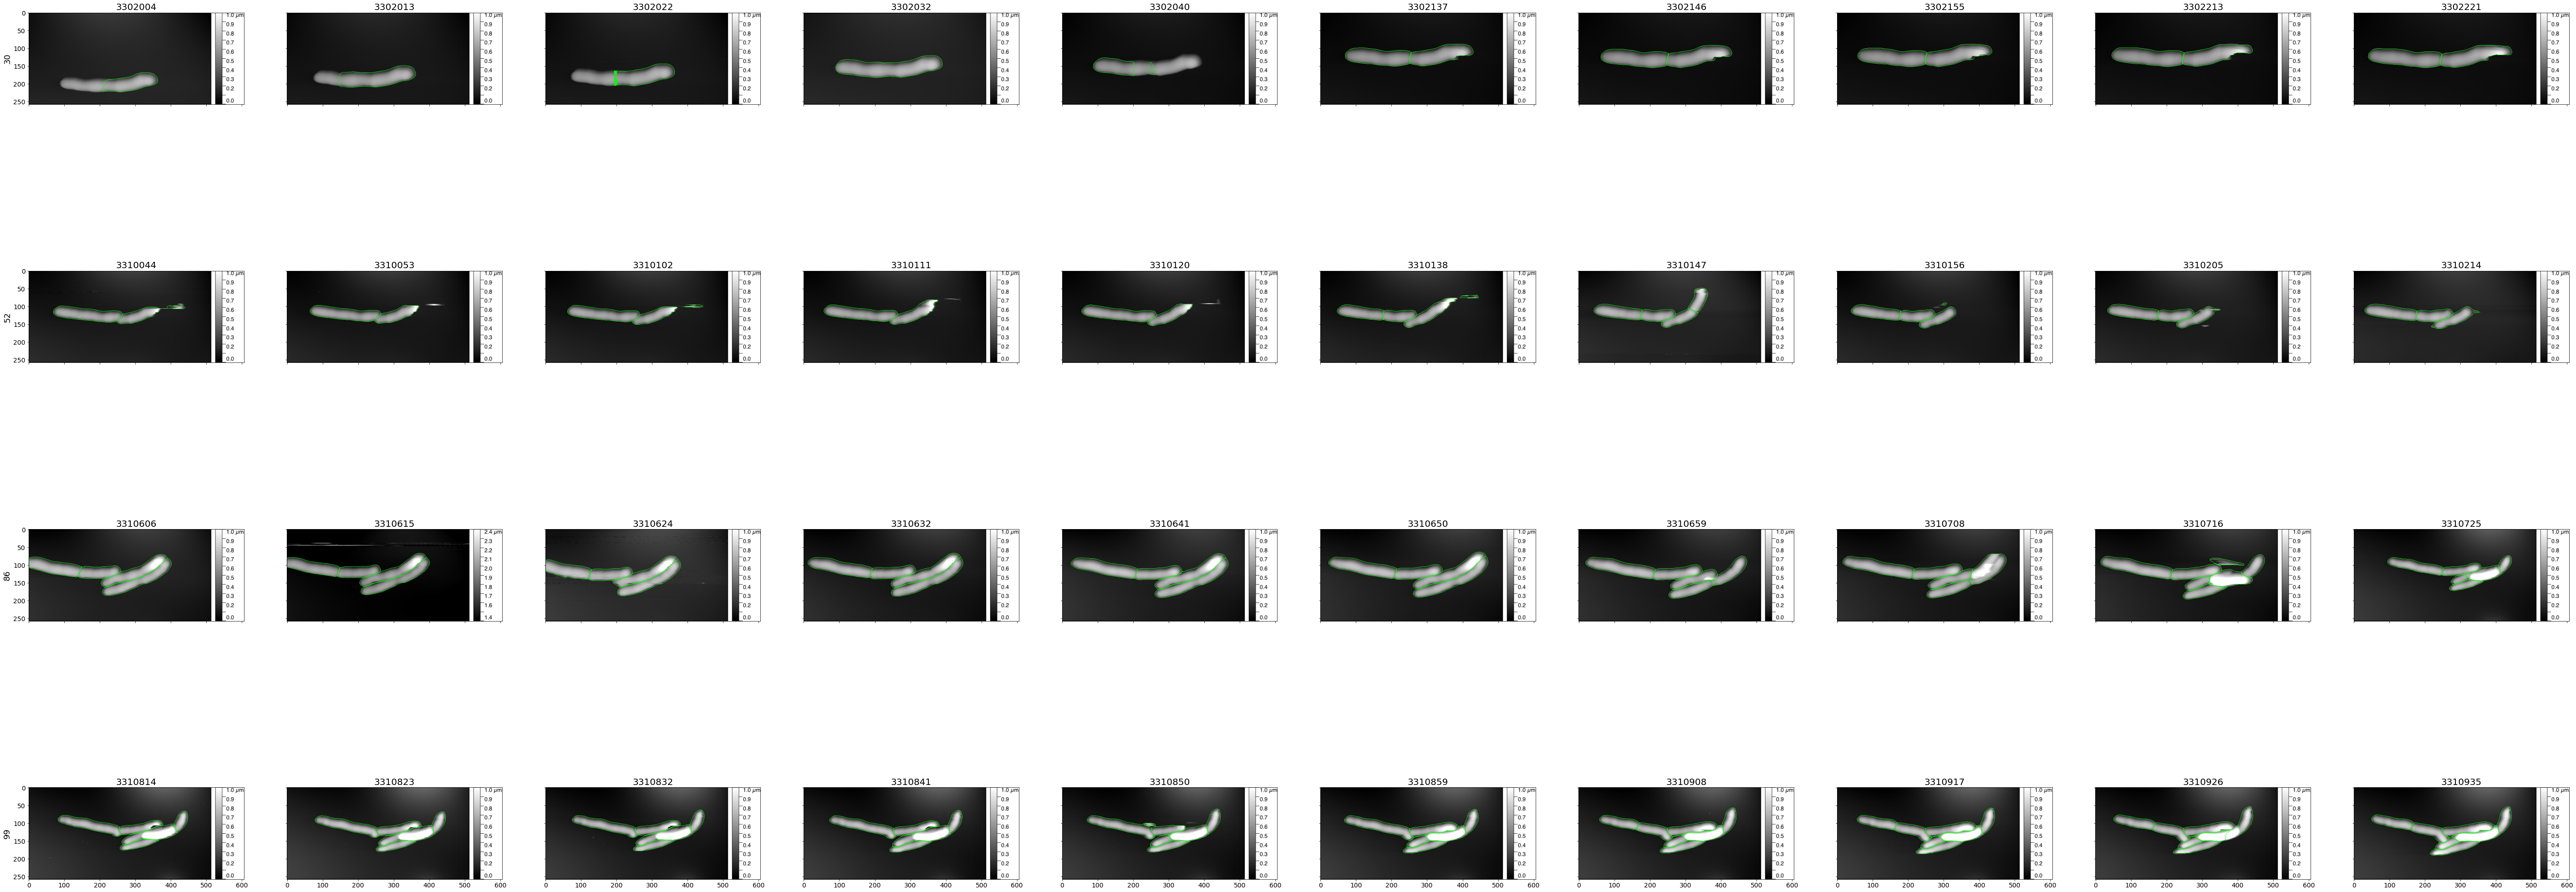

In [57]:
jump_list,cor_list=find_jumps(num_of_masks,5)

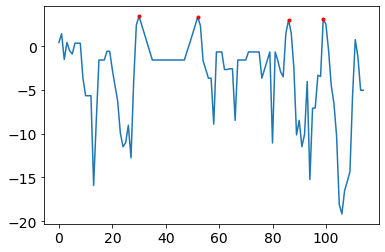

In [58]:
plt.plot(cor_list)
for i in jump_list:
    plt.plot(i,cor_list[i],'r.')

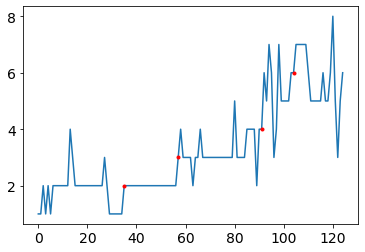

In [61]:
plt.plot(num_of_masks)
for i in jump_list:
    plt.plot(i+5,num_of_masks[i+5],'r.')